<a href="https://colab.research.google.com/github/jh-4166640/Machine-Learning-Lecture/blob/main/FinancePredictModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----
#주가 예측 텀프로젝트
-----

###Train / Test divied

In [68]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdrhrk

shinpoong_pharm_finance = yf.download('019170.KS', start='2022-05-01') # 주가가 큰 변동이 없을 때
robostar_finance = yf.download('090360.KQ', start='2024-04-01')        # 변동성이 가장 큰 주식으로 이상치 데이터로 사용하기 위함
daihan_pharm_finance = yf.download('023910.KQ', start='2021-09-01')    # 큰 변동성이 최대한 없는 부분부터
dbhitek_finance = yf.download('000990.KS', start='2022-07-01')         # 상승하는 부분부터 사용하기 위해서
skdnd_finance = yf.download('210980.KS', start='2024-04-01')           # 너무 큰 급락 폭을무시하기 위해서

# train, test divied
shinpoong_train_idx = np.where('2025-10-20'>shinpoong_pharm_finance.index)
robostar_train_idx = np.where('2025-10-20'>robostar_finance.index)
daihan_train_idx = np.where('2025-10-20'>daihan_pharm_finance.index)
dbhitek_train_idx = np.where('2025-10-20'>dbhitek_finance.index)
skdnd_train_idx = np.where('2025-10-20'>skdnd_finance.index)

shinpoong_test_idx = np.where('2025-10-20'<=shinpoong_pharm_finance.index)
robostar_test_idx = np.where('2025-10-20'<=robostar_finance.index)
daihan_test_idx = np.where('2025-10-20'<=daihan_pharm_finance.index)
dbhitek_test_idx = np.where('2025-10-20'<=dbhitek_finance.index)
skdnd_test_idx = np.where('2025-10-20'<=skdnd_finance.index)




/tmp/ipython-input-1308427316.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  shinpoong_pharm_finance = yf.download('019170.KS', start='2022-05-01') # 주가가 큰 변동이 없을 때
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1308427316.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  robostar_finance = yf.download('090360.KQ', start='2024-04-01')        # 변동성이 가장 큰 주식으로 이상치 데이터로 사용하기 위함
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1308427316.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daihan_pharm_finance = yf.download('023910.KQ', start='2021-09-01')    # 큰 변동성이 최대한 없는 부분부터
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1308427316.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dbhitek_finance = yf.download('000990.KS', s

###기술적 지표 추가

In [69]:

# NaN 제거 - GPT 활용
def clean_nan(data, method="drop"):
    """
    data: pandas DataFrame
    method: 'drop', 'bfill', 'ffill', 'bothfill'
    """
    if method == "drop":
        return data.dropna()

    elif method == "bfill":
        return data.fillna(method="bfill")

    elif method == "ffill":
        return data.fillna(method="ffill")

    elif method == "bothfill":
        return data.fillna(method="ffill").fillna(method="bfill")

    else:
        raise ValueError("method must be: 'drop', 'bfill', 'ffill', 'bothfill'")


# 단순 이동평균선 데이터 + 불린저 밴드 사용
def BollingerBand(data, window=9):
  # SMA20
  data[f'BB_MID_{window}'] = data['Close'].rolling(window=window).mean()
  # 표준편차
  data[f'BB_STD_{window}'] = data['Close'].rolling(window=window).std()
  # 상단 밴드
  data[f'BB_UPPER_{window}'] = data[f'BB_MID_{window}'] + (2 * data[f'BB_STD_{window}'])
  # 하단 밴드
  data[f'BB_LOWER_{window}'] = data[f'BB_MID_{window}'] - (2 * data[f'BB_STD_{window}'])

  return data

# EMA 지수 이동평균선 사용
def ExpMovingAverage(data, windows=[4, 12]):
  for w in windows:
    data[f'EMA{w}'] = data['Close'].ewm(span=w, adjust=False).mean()
  return data

def add_ticker_id(arr, id_num):
  id_col = np.full((arr.shape[0], 1), id_num)
  return np.hstack([arr, id_col])


sp1=BollingerBand(shinpoong_pharm_finance)
rbs1=BollingerBand(robostar_finance)
dh1=BollingerBand(daihan_pharm_finance)
dbh1=BollingerBand(dbhitek_finance)
skd1=BollingerBand(skdnd_finance)

print((sp1.shape))

sp2=ExpMovingAverage(sp1)
rbs2=ExpMovingAverage(rbs1)
dh2=ExpMovingAverage(dh1)
dbh2=ExpMovingAverage(dbh1)
skd2=ExpMovingAverage(skd1)

sp=clean_nan(sp2,"bothfill")
rbs=clean_nan(rbs2,"bothfill")
dh=clean_nan(dh2,"bothfill")
dbh=clean_nan(dbh2,"bothfill")
skd=clean_nan(skd2,"bothfill")

np_sp = sp.values
np_rbs = rbs.values
np_dh = dh.values
np_dbh = dbh.values
np_skd = skd.values
print(np_sp.shape)


np_sp = add_ticker_id(np_sp, 1)
np_rbs = add_ticker_id(np_rbs,2)
np_dh = add_ticker_id(np_dh,3)
np_dbh = add_ticker_id(np_dbh,4)
np_skd = add_ticker_id(np_skd,5)

print(np_sp.shape)



(882, 9)
(882, 11)
(882, 12)


/tmp/ipython-input-1221904741.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method="ffill").fillna(method="bfill")


In [70]:
def minmax_normalize_np(data, feature_idx=None, return_params=True):
    """
    data: 2D numpy array (행: 날짜, 열: feature)
    feature_idx: 정규화할 열 인덱스 리스트, None이면 전체 열
    return_params: True면 min/max 값도 반환
    """
    data_norm = data.copy()
    if feature_idx is None:
        feature_idx = np.arange(data.shape[1])

    min_vals = {}
    max_vals = {}

    for idx in feature_idx:
        col = data[:, idx]
        min_val = col.min()
        max_val = col.max()
        min_vals[idx] = min_val
        max_vals[idx] = max_val

        if max_val - min_val == 0:
            data_norm[:, idx] = 0.0
        else:
            data_norm[:, idx] = (col - min_val) / (max_val - min_val)

    if return_params:
        return data_norm, min_vals, max_vals
    else:
        return data_norm

def std_normalize_np(data, feature_idx=None, return_params=True):
    """
    data: 2D numpy array (행: 날짜, 열: feature)
    feature_idx: 정규화할 열 인덱스 리스트, None이면 전체 열
    return_params: True면 mean/std 반환
    """
    data_norm = data.copy()

    if feature_idx is None:
        feature_idx = np.arange(data.shape[1])

    mean_vals = {}
    std_vals = {}

    for idx in feature_idx:
        col = data[:, idx]
        mean = col.mean()
        std = col.std()

        mean_vals[idx] = mean
        std_vals[idx] = std

        if std == 0:
            data_norm[:, idx] = 0.0
        else:
            data_norm[:, idx] = (col - mean) / std

    if return_params:
        return data_norm, mean_vals, std_vals
    else:
        return data_norm


# np_sp_norm, sp_min, sp_max = minmax_normalize_np(np_sp)
# np_rbs_norm, rbs_min, rbs_max = minmax_normalize_np(np_rbs)
# np_dh_norm, dh_min, dh_max = minmax_normalize_np(np_dh)
# np_dbh_norm, dbh_min, dbh_max = minmax_normalize_np(np_dbh)
# np_skd_norm, skd_min, skd_max = minmax_normalize_np(np_skd)

np_sp_norm, sp_mean, sp_std = std_normalize_np(np_sp)
np_rbs_norm, rbs_mean, rbs_std = std_normalize_np(np_rbs)
np_dh_norm, dh_mean, dh_std = std_normalize_np(np_dh)
np_dbh_norm, dbh_mean, dbh_std = std_normalize_np(np_dbh)
np_skd_norm, skd_mean, skd_std = std_normalize_np(np_skd)

# train set divide
# 신풍제약
np_sp_train_norm = np_sp_norm[shinpoong_train_idx,:]
np_sp_train_norm = np_sp_train_norm.reshape(-1,np_sp_train_norm.shape[2])
# 로보스타
np_rbs_train_norm = np_rbs_norm[robostar_train_idx,:]
np_rbs_train_norm = np_rbs_train_norm.reshape(-1,np_rbs_train_norm.shape[2])
# 대한약품
np_dh_train_norm = np_dh_norm[daihan_train_idx,:]
np_dh_train_norm = np_dh_train_norm.reshape(-1,np_dh_train_norm.shape[2])
# DB하이텍
np_dbh_train_norm = np_dbh_norm[dbhitek_train_idx,:]
np_dbh_train_norm = np_dbh_train_norm.reshape(-1,np_dbh_train_norm.shape[2])
# SK D&D
np_skd_train_norm = np_skd_norm[skdnd_train_idx,:]
np_skd_train_norm = np_skd_train_norm.reshape(-1,np_skd_train_norm.shape[2])

# test set divide
# 신풍제약
np_sp_test_norm = np_sp_norm[shinpoong_test_idx,:]
np_sp_test_norm = np_sp_test_norm.reshape(-1,np_sp_test_norm.shape[2])
# 로보스타
np_rbs_test_norm = np_rbs_norm[robostar_test_idx,:]
np_rbs_test_norm = np_rbs_test_norm.reshape(-1,np_rbs_test_norm.shape[2])
# 대한약품
np_dh_test_norm = np_dh_norm[daihan_test_idx,:]
np_dh_test_norm = np_dh_test_norm.reshape(-1,np_dh_test_norm.shape[2])
# DB하이텍
np_dbh_test_norm = np_dbh_norm[dbhitek_test_idx,:]
np_dbh_test_norm = np_dbh_test_norm.reshape(-1,np_dbh_test_norm.shape[2])
# SK D&D
np_skd_test_norm = np_skd_norm[skdnd_test_idx,:]
np_skd_test_norm = np_skd_test_norm.reshape(-1,np_skd_test_norm.shape[2])

print(f"All {np_sp_norm.shape}, train {np_sp_train_norm.shape}, test {np_sp_test_norm.shape}")
print(f"All {np_rbs_norm.shape}, train {np_rbs_train_norm.shape}, test {np_rbs_test_norm.shape}")
print(f"All {np_dh_norm.shape}, train {np_dh_train_norm.shape}, test {np_dh_test_norm.shape}")
print(f"All {np_dbh_norm.shape}, train {np_dbh_train_norm.shape}, test {np_dbh_test_norm.shape}")
print(f"All {np_skd_norm.shape}, train {np_skd_train_norm.shape}, test {np_skd_test_norm.shape}")


# # 정규화 해서 list에 저장
np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
np_test_list_norm = [np_sp_test_norm, np_rbs_test_norm, np_dh_test_norm, np_dbh_test_norm, np_skd_test_norm]
# 로보 스타 뺀거
# np_train_list_norm = [np_sp_train_norm,  np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
# np_test_list_norm = [np_sp_test_norm, np_rbs_test_norm, np_dh_test_norm, np_dbh_test_norm, np_skd_test_norm]




All (882, 12), train (844, 12), test (38, 12)
All (412, 12), train (374, 12), test (38, 12)
All (1033, 12), train (995, 12), test (38, 12)
All (842, 12), train (804, 12), test (38, 12)
All (411, 12), train (373, 12), test (38, 12)


##학습 데이터 준비

In [71]:
future = 4
target_idx = [0,1,2,3]
lookback = 6 # 3~20 사이 값
# np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
x_train, t_train = [], []
for data in np_train_list_norm:
    # 이미 정규화, NaN 처리 완료된 상태
    for idx in range(data.shape[0] - lookback - future):
        x_train.append(data[idx:idx+lookback])
        t_train.append(data[idx+lookback:idx+lookback +future,0:4])  # 예: Close,

x_train=np.array(x_train)
t_train=np.array(t_train)

# for data in np_train_list_norm:
#     # data: (T, features), 이미 min-max norm 상태

#     for idx in range(data.shape[0] - lookback - future):
#         # 입력: 과거 lookback
#         x_seq = data[idx:idx + lookback]

#         # 기준 가격 (lookback 마지막 시점)
#         last_price = data[idx + lookback - 1, target_idx]

#         # 미래 가격
#         future_price = data[idx + lookback: idx + lookback + future, target_idx]

#         # ✅ 변화량 (delta)
#         delta = future_price - last_price

#         x_train.append(x_seq)
#         t_train.append(delta)

x_train = np.array(x_train)      # (N, lookback, features)
t_train = np.array(t_train)      # (N, future, 4)

print(x_train.shape, t_train.shape)

(3340, 6, 12) (3340, 4, 4)


##모델 정의

In [72]:
import keras
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout,Input,ELU, Reshape, Add, RepeatVector, TimeDistributed, AdditiveAttention, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam

feature_n = np_sp_train_norm.shape[1]
output_n = 4
dropout_rate = 0.2

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2,strides=1,padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=128, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=256, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)

# x = LSTM(128, activation='tanh',return_sequences=False)(x)
# x = Dropout(rate = dropout_rate)(x)
# x = Dense(output_n*future)(x)
# output_layer = Reshape((future,output_n))(x)

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2,strides=1,padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=128, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)
# # x = Conv1D(filters=256, kernel_size=2,strides=1,padding="same")(x)
# # x = ELU(alpha=1.0)(x)
# x = Dense(128, activation='tanh')(x)
# # x = Dense(256, activation='tanh')(x)
# x = Dropout(rate = dropout_rate)(x)
# x = LSTM(128, return_sequences=False)(x)
# x = RepeatVector(future)(x)

# x = LSTM(128, return_sequences=True)(x)
# output_layer = TimeDistributed(Dense(output_n))(x)

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2, strides=1, padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# # x = Conv1D(filters=128, kernel_size=2, strides=1, padding="same")(x)
# # x = ELU(alpha=1.0)(x)
# x = Dense(512, activation='tanh')(x)
# x = Dropout(rate = dropout_rate)(x)
# encoder_output = LSTM(256, return_sequences=True)(x)
# attention_output = AdditiveAttention(use_scale=True)([encoder_output, encoder_output])
# context_vector = GlobalAveragePooling1D()(attention_output)
# decoder_input = RepeatVector(future)(context_vector) # shape: (None, 4, 128)
# decoder_output = LSTM(256, return_sequences=True)(decoder_input) # shape: (None, 4, 128)
# output_layer = TimeDistributed(Dense(output_n))(decoder_output) # shape: (None, 4, 4)

input_layer = Input(shape=(lookback, feature_n))
x = Conv1D(filters=64, kernel_size=2, strides=1, padding="same")(input_layer)
x = ELU(alpha=1.0)(x)
x = Dense(128, activation='tanh')(x)
x = Dropout(rate = dropout_rate)(x)
x = Dense(256, activation='tanh')(x)

context_vector = LSTM(256, return_sequences=False)(x)

x = RepeatVector(future)(context_vector)
x = LSTM(256, return_sequences=True)(x)
output_layer = TimeDistributed(Dense(output_n))(x) # 최종 Shape: (None, 4, 4)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(
    learning_rate=0.0028,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)
# model.compile(
#     optimizer=optimizer,
#     loss=keras.losses.MeanSquaredError(),
#     metrics=[keras.metrics.MeanSquaredError()]
# )
model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.0),
    metrics=[keras.metrics.MeanSquaredError()]
)
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 6, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 6, 64)          │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_7 (ELU)                     │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6, 128)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6, 256)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 4, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 4, 4)           │         1,028 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,094,596 (4.18 MB)

 Trainable params: 1,094,596 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

##Model 학습

In [73]:
# 현재는 종목별 특징을 고려 안함
# 종목별 특징을 사용하고 싶으면 종목 ticker 열을 추가해서 학습

epoch =1500
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,        # validation_loss 기준 최적 모델만 저장
    monitor="val_loss",
    mode="min"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,               # 30 Epoch 동안 개선 없으면 종료
    restore_best_weights=True  # 종료 시 최적 가중치 복원
)

#history = model.fit(x_train,t_train,epochs=epoch,batch_size=64,callbacks=[checkpoint_cb, earlystop_cb])
history = model.fit(x_train,t_train,epochs=epoch,batch_size=64)

Epoch 1/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1239 - mean_squared_error: 0.2769
Epoch 2/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0308 - mean_squared_error: 0.0624
Epoch 3/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0291 - mean_squared_error: 0.0592
Epoch 4/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 - mean_squared_error: 0.0569
Epoch 5/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0288 - mean_squared_error: 0.0585
Epoch 6/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0288 - mean_squared_error: 0.0587
Epoch 7/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0236 - mean_squared_error: 0.0478
Epoch 8/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0251 - mean_squared_error: 0.0510
Epoch 9/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - mean_squared_error: 0.0480
Epoch 10/1500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0382 - mean_squared_error: 0.0775
Epoch 11/1500
53/53 ━━━━━━━━━━━━━━━━━━━

##예측 검증

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


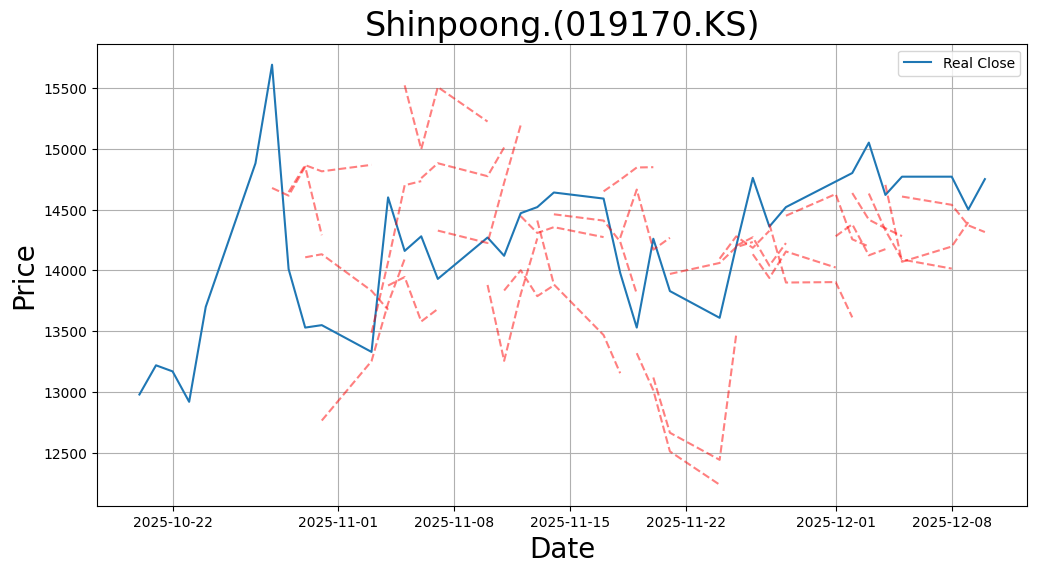

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


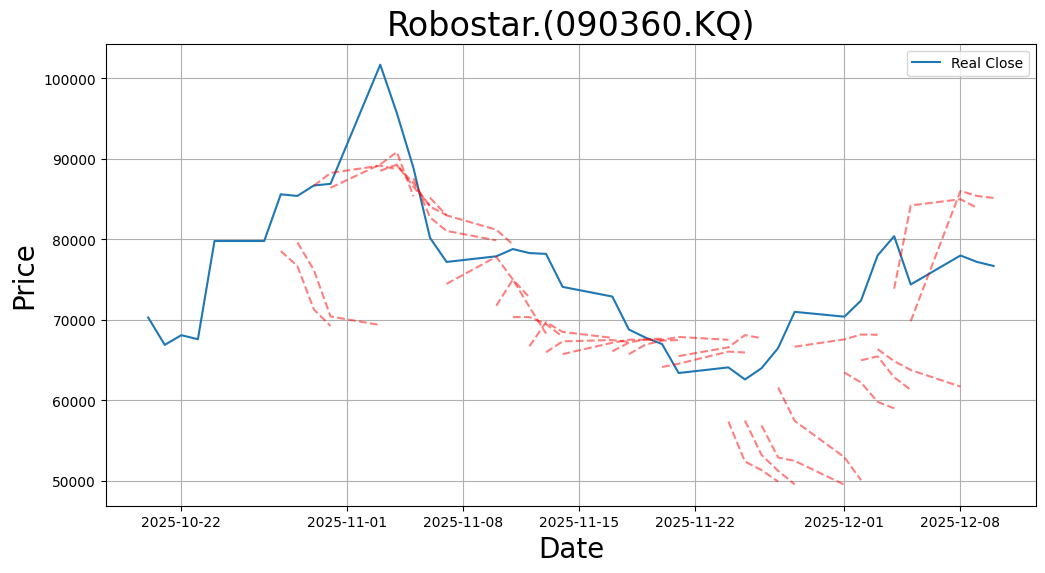

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


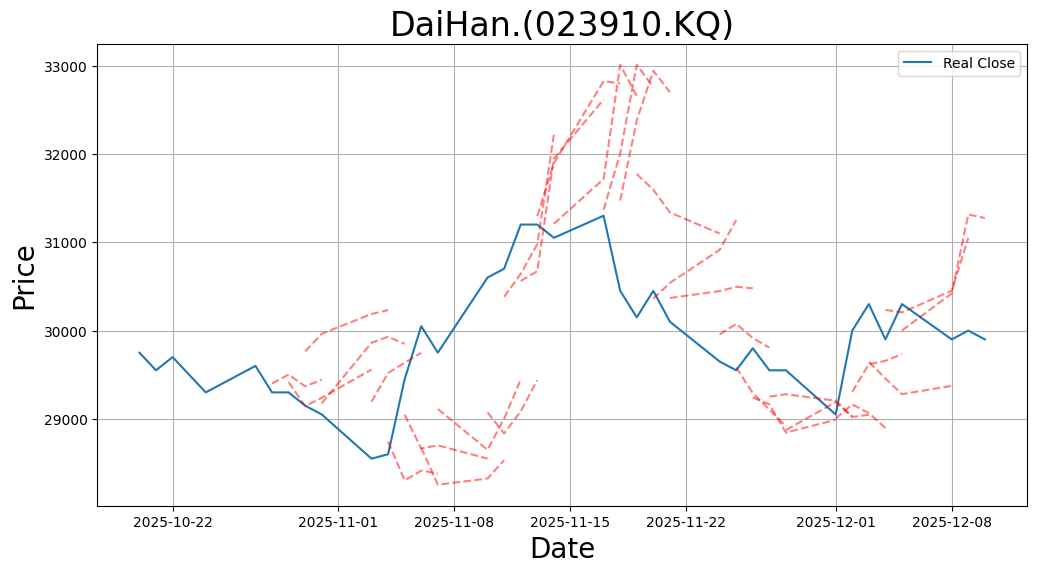

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


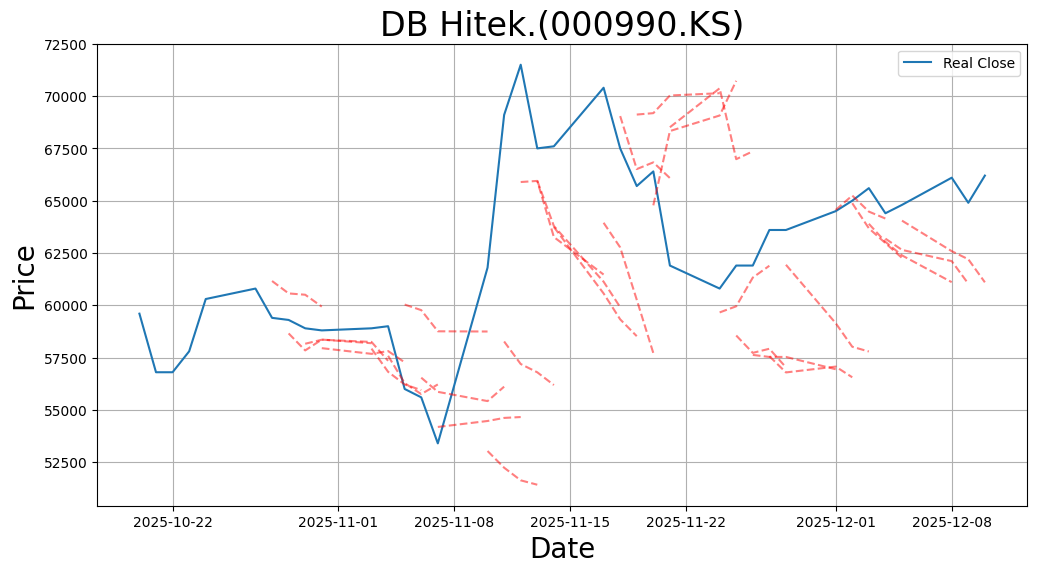

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


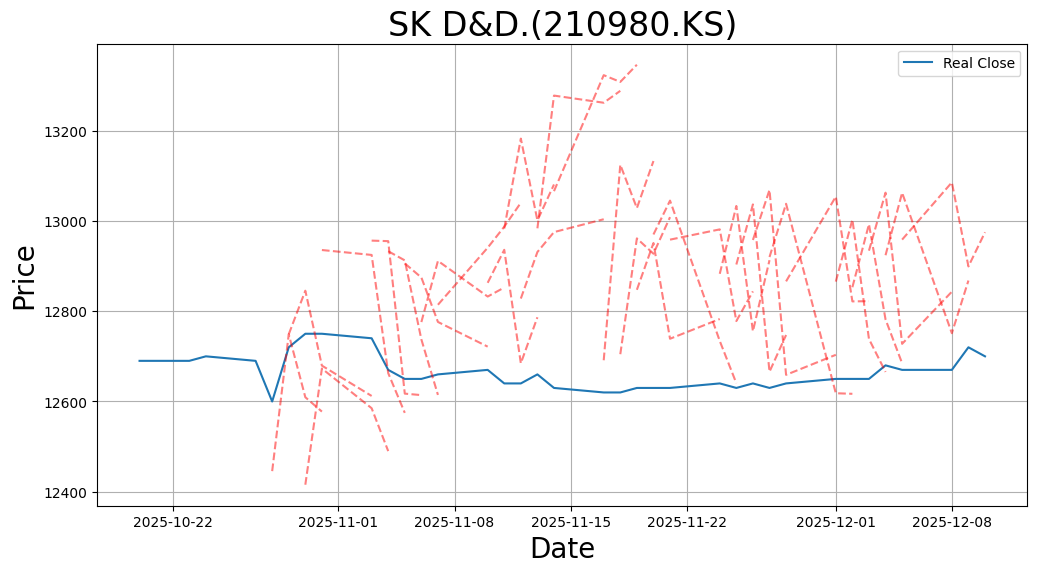

| 종목명                |   MSE (평균 제곱 오차) |   RMSE (제곱근 평균 제곱 오차) |    RMSE |              MSE |
|:----------------------|-----------------------:|-------------------------------:|--------:|-----------------:|
| Shinpoong.(019170.KS) |       469663           |                        685.32  |  685.32 | 469663           |
| Robostar.(090360.KQ)  |            9.19565e+07 |                       9589.4   | 9589.4  |      9.19565e+07 |
| DaiHan.(023910.KQ)    |            1.36149e+06 |                       1166.83  | 1166.83 |      1.36149e+06 |
| DB Hitek.(000990.KS)  |            3.84764e+07 |                       6202.94  | 6202.94 |      3.84764e+07 |
| SK D&D.(210980.KS)    |        85896.7         |                        293.081 |  293.08 |  85896.6         |


In [74]:
##4일 통으로 예측

import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error

def denormalize(y_norm, min_vals, max_vals,feature_indices=[0,1,2,3]):
    y = y_norm.copy()
    for i, idx in enumerate(feature_indices):
        y[:, i] = y[:, i] * (max_vals[idx] - min_vals[idx]) + min_vals[idx]
    return y

def denormalize_std(y_norm, mean_vals, std_vals, feature_indices=[0,1,2,3]):
    y = y_norm.copy()
    for idx in feature_indices:
        y[..., idx] = y[..., idx] * std_vals[idx] + mean_vals[idx]
    return y


def recursive_predict(
    model,
    x_start_norm,
    future_days=4,
    price_feat_idx=[0,1,2,3]
):
    preds = []
    x_cur = x_start_norm.copy()   # (lookback, features)

    for _ in range(future_days):
        y_pred_norm = model.predict(
            x_cur[np.newaxis, ...],
            verbose=0
        )
        next_day = y_pred_norm[0, 0]   # (4,)
        preds.append(next_day)

        # 입력 갱신 (shift + 예측값 삽입)
        x_next = x_cur.copy()
        x_next[:-1] = x_cur[1:]
        x_next[-1, price_feat_idx] = next_day
        x_cur = x_next

    return np.array(preds)   # (4, 4)

# 모델 로드
best_model = load_model("best_model.h5")

# minmax_vals = [
#     [sp_min, sp_max],
#     [rbs_min, rbs_max],
#     [dh_min, dh_max],
#     [dbh_min, dbh_max],
#     [skd_min, skd_max]
# ]

std_vals = [
    (sp_mean, sp_std),
    (rbs_mean, rbs_std),
    (dh_mean, dh_std),
    (dbh_mean, dbh_std),
    (skd_mean, skd_std)
]


titles = [
    "Shinpoong.(019170.KS)",
    "Robostar.(090360.KQ)",
    "DaiHan.(023910.KQ)",
    "DB Hitek.(000990.KS)",
    "SK D&D.(210980.KS)"
]

future_days = 4
all_mse = []
all_rmse = []
# 테스트 루프 (4일 통 예측)
for i, data in enumerate(np_test_list_norm):
    test_data_norm = data.copy()
    x_test_norm, y_true_norm = [], []

    # future=4를 사용했으므로 range는 (data.shape[0] - lookback - future + 1) 로 변경
    for idx in range(data.shape[0] - lookback - future + 1):
        x_test_norm.append(data[idx:idx+lookback])
        y_true_norm.append(data[idx+lookback:idx+lookback+future,0:4])

    x_test_norm = np.array(x_test_norm)
    y_true_norm = np.array(y_true_norm)

    # 예측: 모델에 테스트 데이터를 한 번에 넣고 4일치 예측 결과를 얻음
    y_pred_norm = best_model.predict(x_test_norm)

    # ... (역정규화 코드 생략, 기존 코드의 mean/std 활용)
    mean_vals, std_vals_i = std_vals[i]

    test_data = test_data_norm.copy()
    test_data[:,0:4] = denormalize_std(
        test_data[:,0:4],
        mean_vals,
        std_vals_i
    )

    y_true = denormalize_std(y_true_norm, mean_vals, std_vals_i)
    y_pred = denormalize_std(y_pred_norm, mean_vals, std_vals_i)

    # Plot (4일 통 예측 결과 시각화)
    plt.figure(figsize=(12,6))
    dates_full = shinpoong_pharm_finance.index[shinpoong_test_idx]

    plt.plot(dates_full, test_data[:,0], label="Real Close")

    # 예측 결과를 실제 시점(dates_full)에 맞게 그리기
    for w in range(len(y_pred)):
        base_idx = w + lookback
        dates_w = dates_full[base_idx:base_idx+future]

        # y_pred[w, :, 0] 는 w 시점에서 예측한 미래 4일의 Close 가격
        plt.plot(
            dates_w,
            y_pred[w, :, 0],
            color='red',
            alpha=0.5,
            linestyle='--'
        )
    y_true_close = y_true[..., 0].flatten()
    y_pred_close = y_pred[..., 0].flatten()

    # MSE 및 RMSE 계산
    mse = mean_squared_error(y_true_close, y_pred_close)
    rmse = np.sqrt(mse)

    all_mse.append(mse)
    all_rmse.append(rmse)

    plt.title(titles[i], fontsize=24)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()
results_df = pd.DataFrame({
    '종목명': titles,
    'MSE (평균 제곱 오차)': all_mse,
    'RMSE (제곱근 평균 제곱 오차)': all_rmse
})

results_df['RMSE'] = results_df['RMSE (제곱근 평균 제곱 오차)'].round(2)
results_df['MSE'] = results_df['MSE (평균 제곱 오차)'].round(2)

print(results_df.to_markdown(index=False))

In [75]:
# import matplotlib.pyplot as plt
# from keras.models import load_model

# def denormalize(y_norm, min_vals, max_vals,feature_indices=[0,1,2,3]):
#     y = y_norm.copy()
#     for i, idx in enumerate(feature_indices):
#         y[:, i] = y[:, i] * (max_vals[idx] - min_vals[idx]) + min_vals[idx]
#     return y

# def denormalize_std(y_norm, mean_vals, std_vals, feature_indices=[0,1,2,3]):
#     y = y_norm.copy()
#     for idx in feature_indices:
#         y[..., idx] = y[..., idx] * std_vals[idx] + mean_vals[idx]
#     return y


# def recursive_predict(
#     model,
#     x_start_norm,
#     future_days=4,
#     price_feat_idx=[0,1,2,3]
# ):
#     preds = []
#     x_cur = x_start_norm.copy()   # (lookback, features)

#     for _ in range(future_days):
#         y_pred_norm = model.predict(
#             x_cur[np.newaxis, ...],
#             verbose=0
#         )
#         next_day = y_pred_norm[0, 0]   # (4,)
#         preds.append(next_day)

#         # 입력 갱신 (shift + 예측값 삽입)
#         x_next = x_cur.copy()
#         x_next[:-1] = x_cur[1:]
#         x_next[-1, price_feat_idx] = next_day
#         x_cur = x_next

#     return np.array(preds)   # (4, 4)

# # =========================
# # 모델 로드
# # =========================
# best_model = load_model("best_model.h5")

# # minmax_vals = [
# #     [sp_min, sp_max],
# #     [rbs_min, rbs_max],
# #     [dh_min, dh_max],
# #     [dbh_min, dbh_max],
# #     [skd_min, skd_max]
# # ]

# std_vals = [
#     (sp_mean, sp_std),
#     (rbs_mean, rbs_std),
#     (dh_mean, dh_std),
#     (dbh_mean, dbh_std),
#     (skd_mean, skd_std)
# ]


# titles = [
#     "Shinpoong.(019170.KS)",
#     "Robostar.(090360.KQ)",
#     "DaiHan.(023910.KQ)",
#     "DB Hitek.(000990.KS)",
#     "SK D&D.(210980.KS)"
# ]

# future_days = 4

# # =========================
# # 테스트 루프
# # =========================
# for i, data in enumerate(np_test_list_norm):

#     # -------- 데이터 구성 --------
#     x_test_norm = []
#     for idx in range(data.shape[0] - lookback - 1):
#         x_test_norm.append(data[idx:idx+lookback])

#     x_test_norm = np.array(x_test_norm)
#     dates = shinpoong_pharm_finance.index[shinpoong_test_idx]
#     test_data = data.copy()

#     # -------- Recursive 예측 --------
#     all_preds_norm = []
#     for w in range(len(x_test_norm)):
#         preds_4 = recursive_predict(
#             best_model,
#             x_test_norm[w],
#             future_days=future_days
#         )
#         all_preds_norm.append(preds_4)

#     all_preds_norm = np.array(all_preds_norm)
#     # shape: (N, 4, 4)

#     # -------- 역정규화 --------
#     # test_data[:,0:4] = denormalize(
#     #     test_data[:,0:4],
#     #     minmax_vals[i][0],
#     #     minmax_vals[i][1]
#     # )

#     # all_preds = denormalize(
#     #     all_preds_norm.reshape(-1,4),
#     #     minmax_vals[i][0],
#     #     minmax_vals[i][1]
#     # ).reshape(all_preds_norm.shape)
#     mean_vals, std_vals_i = std_vals[i]

#     test_data = test_data.copy()
#     test_data[:,0:4] = denormalize_std(
#         test_data[:,0:4],
#         mean_vals,
#         std_vals_i
#     )

#     all_preds = denormalize_std(
#         all_preds_norm,
#         mean_vals,
#         std_vals_i
#     )

#     # =========================
#     # Plot
#     # =========================
#     plt.figure(figsize=(12,6))
#     plt.plot(dates, test_data[:,0], label="Real Close")

#     for w in range(len(all_preds)):
#         base = w + lookback
#         dates_w = dates[base:base+future_days]
#         if len(dates_w) < future_days:
#             break

#         plt.plot(
#             dates_w,
#             all_preds[w, :, 0],   # Close
#             color="red",
#             linestyle="--",
#             alpha=0.3
#         )

#     plt.title(titles[i])
#     plt.xlabel("Date")
#     plt.ylabel("Price")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


##실제 예측

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
✅ Shinpoong.(019170.KS) 예측 결과 저장 완료 (전치): future_5day_Shinpoong_transposed.csv


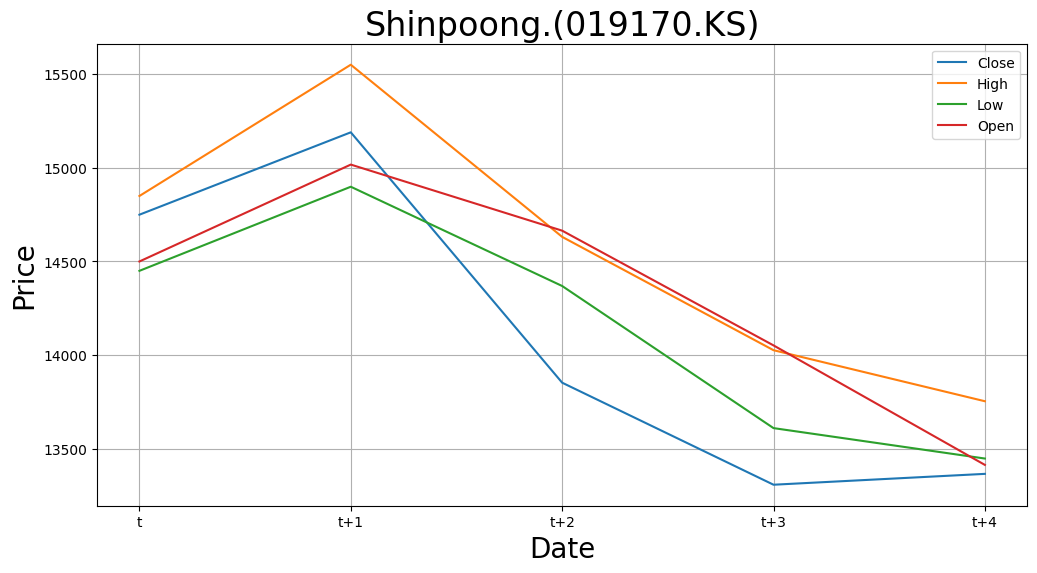

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ Robostar.(090360.KQ) 예측 결과 저장 완료 (전치): future_5day_Robostar_transposed.csv


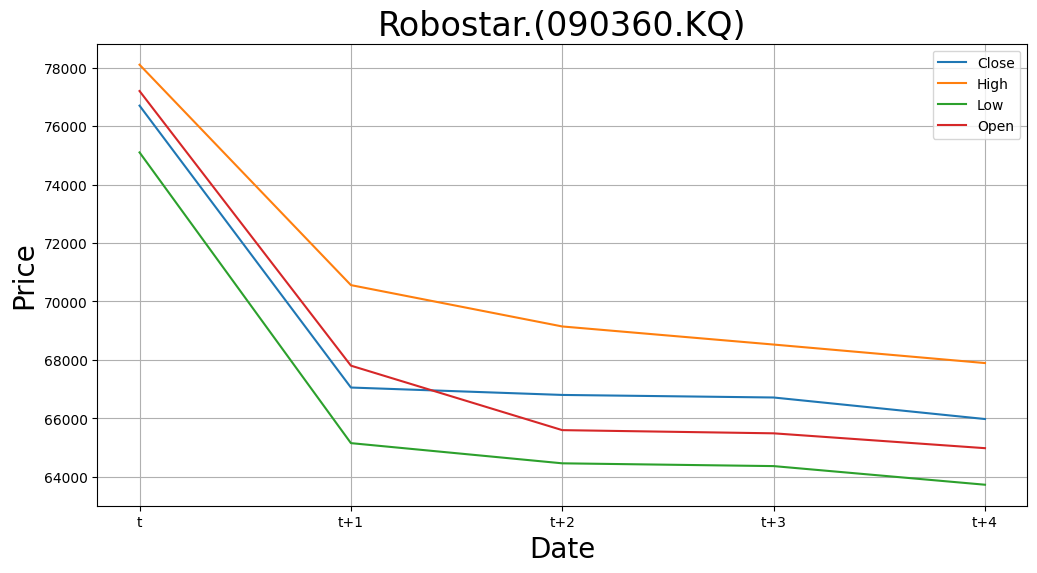

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ DaiHan.(023910.KQ) 예측 결과 저장 완료 (전치): future_5day_DaiHan_transposed.csv


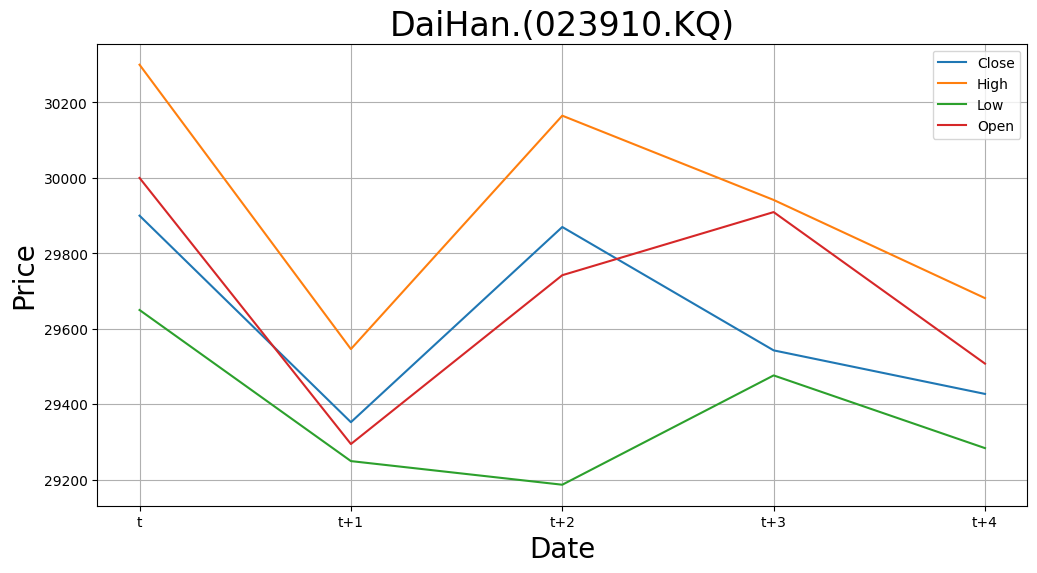

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ DB Hitek.(000990.KS) 예측 결과 저장 완료 (전치): future_5day_DB Hitek_transposed.csv


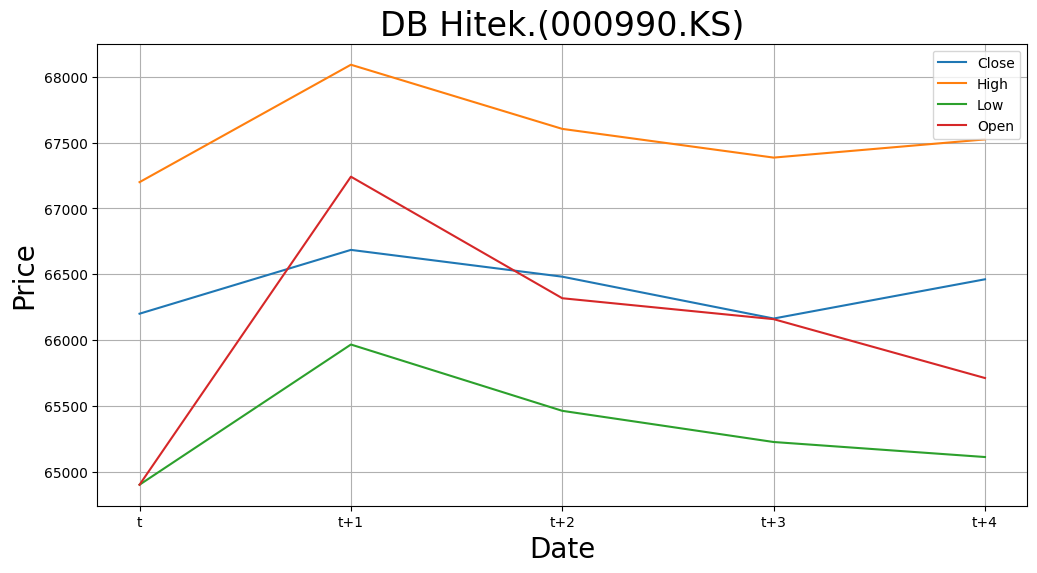

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ SK D&D.(210980.KS) 예측 결과 저장 완료 (전치): future_5day_SK D&D_transposed.csv


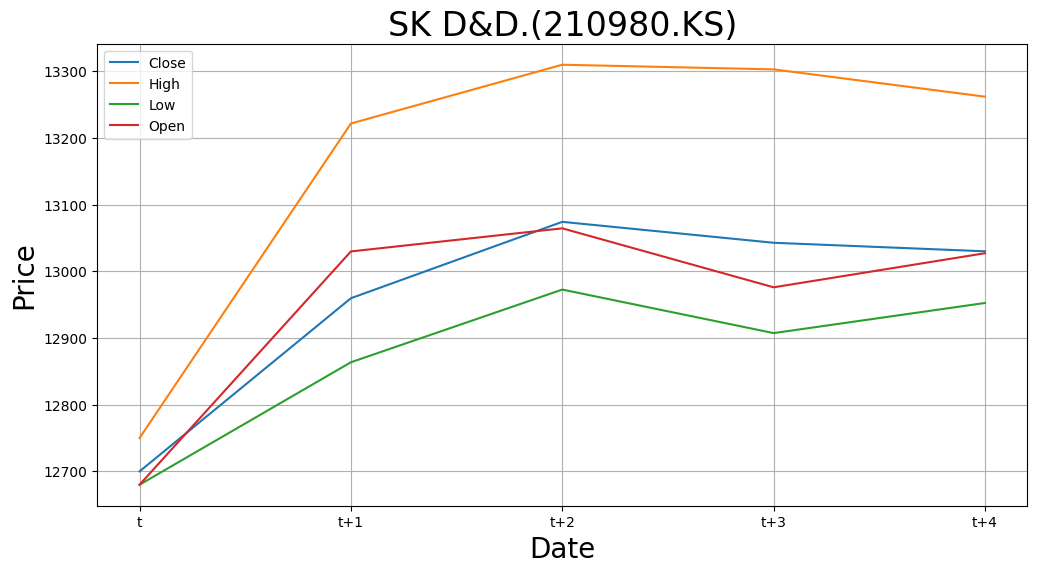

In [76]:
## 실제 예측

import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error

titles = [
    "Shinpoong.(019170.KS)",
    "Robostar.(090360.KQ)",
    "DaiHan.(023910.KQ)",
    "DB Hitek.(000990.KS)",
    "SK D&D.(210980.KS)"
]

future_days = 4
feature_names = ["Close","High","Low", "Open"]
time_steps = ["t","t+1","t+2","t+3","t+4"]
all_csv_results = []
np_finance_list= [np_sp[-1,0:4], np_rbs[-1,0:4], np_dh[-1,0:4],np_dbh[-1,0:4],np_skd[-1,0:4]]


# 테스트 루프 (4일 통 예측)
for i, data in enumerate(np_test_list_norm):
    X_norm = data[-lookback:]

    X_norm = X_norm[np.newaxis, ...]
    Y_pred_norm = best_model.predict(X_norm)
    mean_vals, std_vals_i = std_vals[i]
    Y_pred = denormalize_std(Y_pred_norm[:,0:4],mean_vals,std_vals_i)
    Y_pred=Y_pred.reshape(-1,4)
    np_finance_list[i] = np_finance_list[i][np.newaxis,:]
    t_data_real = np_finance_list[i]
    combined_pred = np.vstack([t_data_real[:,0:4], Y_pred])

    combined_pred_transposed = combined_pred.T

    # 4. DataFrame 생성 (Index와 Column 변경)
    df_pred = pd.DataFrame(
        combined_pred_transposed,
        index=feature_names,       # 행: Close, High, Low, Open
        columns=time_steps         # 열: t, t+1, t+2, t+3, t+4
    )

    # 5. CSV 파일명 지정 및 저장
    stock_title_simple = titles[i].split('.')[0]
    filename = f"future_5day_{stock_title_simple}_transposed.csv" # 파일명 변경

    df_pred.to_csv(filename, float_format='%.2f')

    print(f"✅ {titles[i]} 예측 결과 저장 완료 (전치): {filename}")

    # 6. 통합 CSV 저장을 위한 준비
    # 전치된 형태는 통합이 어려우므로, 종목명과 피처를 컬럼으로 만들어서 저장합니다.
    df_reset = df_pred.reset_index().rename(columns={'index': 'Feature'})
    df_reset.insert(0, 'Stock', stock_title_simple)
    all_csv_results.append(df_reset)

    plt.figure(figsize=(12,6))
    for j in range(4):
        plt.plot(time_steps, combined_pred[:, j], label=feature_names[j])


    plt.title(titles[i], fontsize=24)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()

final_combined_df = pd.concat(all_csv_results, ignore_index=True)
final_csv_name = "all_stocks_future_5day_transposed_combined.csv"
final_combined_df.to_csv(final_csv_name, index=False, float_format='%.2f')


In [77]:

np_finance_list= [np_sp[-1,0:4], np_rbs[-1,0:4], np_dh[-1,0:4],np_dbh[-1,0:4],np_skd[-1,0:4]]
np_finance_list[0] = np_finance_list[0][np.newaxis,:]
print(np_finance_list[0].shape)

(1, 4)
